In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import h5py

import pynbody
from pynbody.analysis import profile

In [2]:
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rcParams['font.size']=12

In [3]:
with open('/home/ryan/Downloads/ExpansionList_128', 'r') as f:
    lines = f.read().split('\n')



a = np.array([ float(l.strip().split(' ')[0]) for l in lines if l])


z = 1/a - 1

[ print(f'{x:.2f}') for x in z ];

FileNotFoundError: [Errno 2] No such file or directory: '/home/ryan/Downloads/ExpansionList_128'

In [4]:
data_path = "C:/Data/"

In [9]:
f = pynbody.load(data_path + '/run_2cDM_L3N256_HY_powerm2m2_sigma1/snap_007.hdf5')
h = f.halos(subhalos=True)

f.physical_units()

pynbody.analysis.faceon(h[0])

C:\Users\ryanm\AppData\Roaming\Python\Python311\site-packages\pynbody\snapshot\gadgethdf.py:761: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


<Transformation faceon>

C:\Users\ryanm\AppData\Roaming\Python\Python311\site-packages\pynbody\kdtree\__init__.py:353: RuntimeWarning: 

The particles span a region larger than the specified boxsize; disabling periodicity.

For more information about this warning, see the module documentation for KDTree, 
https://pynbody.readthedocs.io/latest/reference/_autosummary/pynbody.kdtree.KDTree.html
  smx = kdmain.nn_start(self.kdtree, int(nn), self.boxsize)


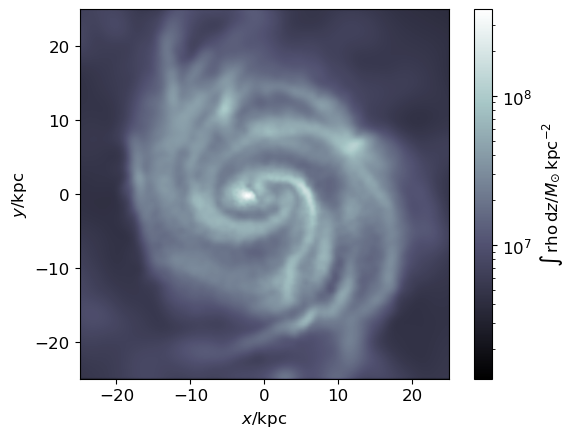

In [7]:
pynbody.plot.image(f.gas, width="50 kpc", units="Msol kpc^-2", cmap="bone")

C:\Users\ryanm\AppData\Roaming\Python\Python311\site-packages\pynbody\array\__init__.py:368: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)


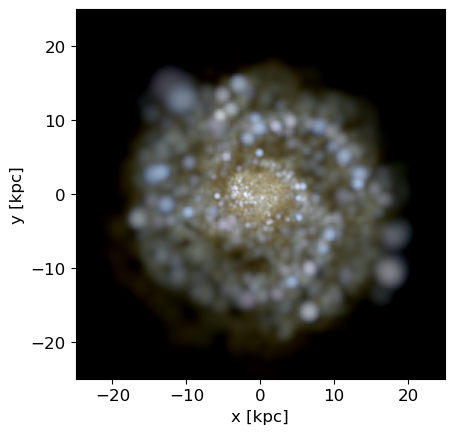

In [8]:
pynbody.plot.stars.render(f.st, width="50 kpc", mag_range=[18, 26])

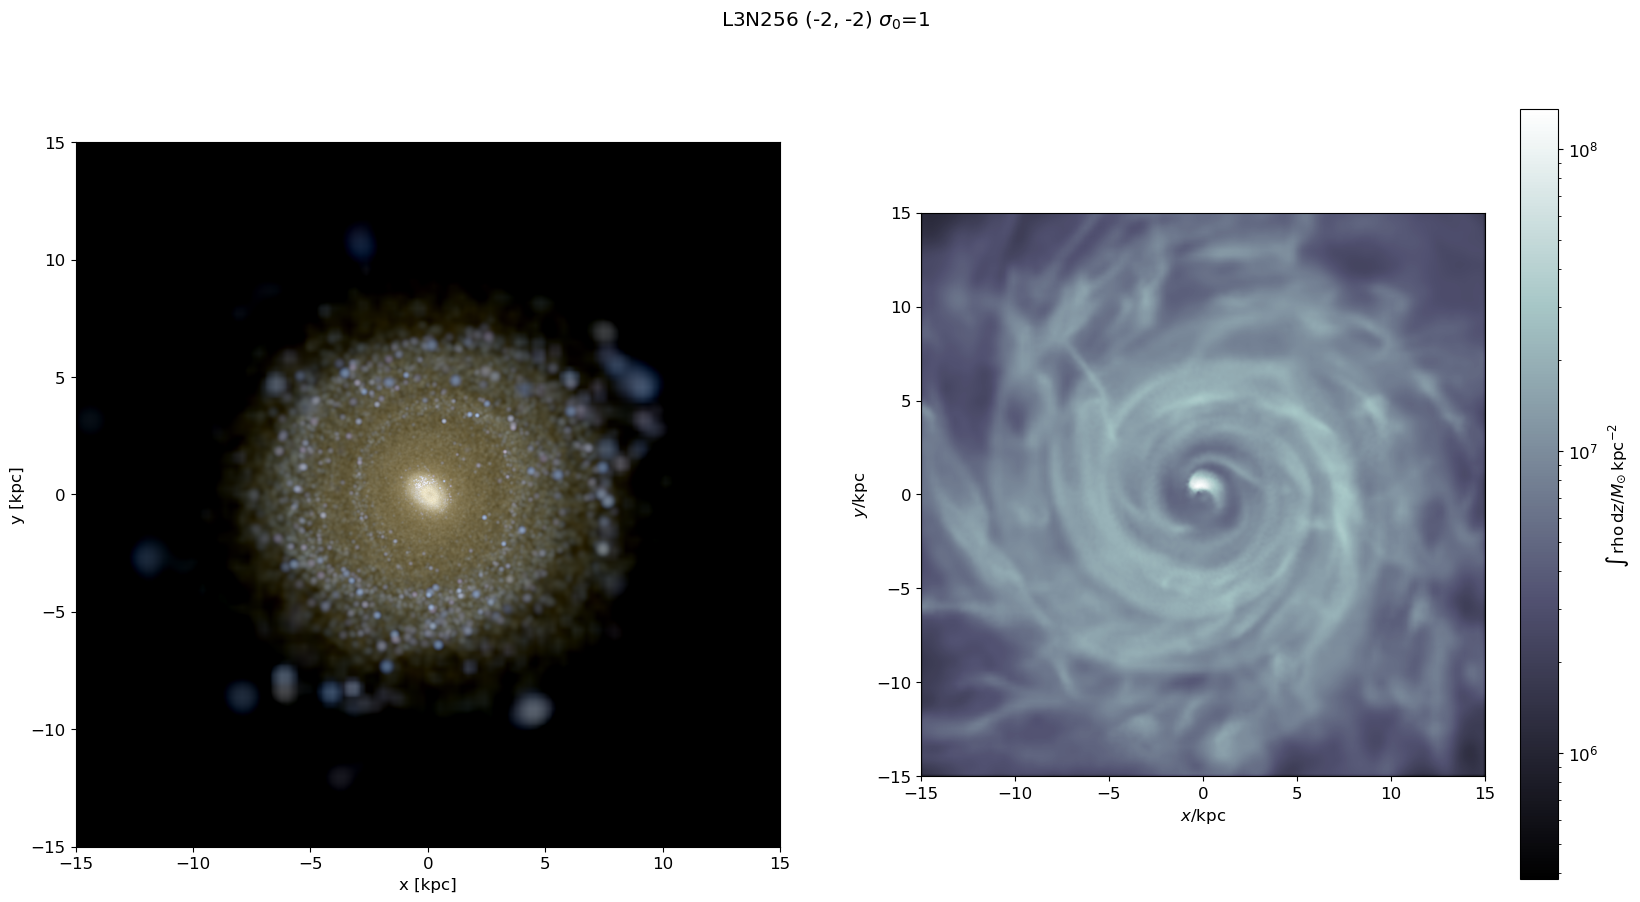

In [14]:
fig, ax = plt.subplots(1, 2, figsize=[20, 10])

plt.sca(ax[0])

pynbody.plot.stars.render(f.st, width="30 kpc", mag_range=[18, 26])

plt.sca(ax[1])

pynbody.plot.image(f.gas, width="30 kpc", units="Msol kpc^-2", cmap="bone", axes=ax[1])

plt.suptitle('L3N256 (-2, -2) $\\sigma_0$=1')

plt.savefig('test.png')

plt.show()

In [111]:
f.loadable_keys()

['phi',
 'mass',
 'SubfindHsml',
 'vel',
 'SubfindDensity',
 'SubfindDMDensity',
 'iord',
 'SubfindVelDisp',
 'pos',
 'eps']

In [100]:
pdm_3d = profile.Profile(f.dm, rmin = '.01 kpc', rmax = '500 kpc', ndim = 3)

p_3d = profile.Profile(h[0], rmin = '.05 kpc', rmax = '100 kpc', ndim = 3)

[]

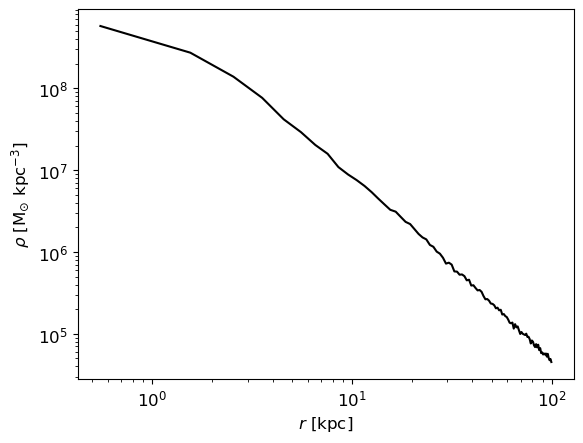

In [101]:
plt.plot(p_3d['rbins'].in_units('kpc'),p_3d['density'].in_units('Msol kpc^-3'),'k')
plt.xlabel('$r$ [kpc]'); plt.ylabel(r'$\rho$ [M$_{\odot}$ kpc$^{-3}$]'); plt.loglog()

[]

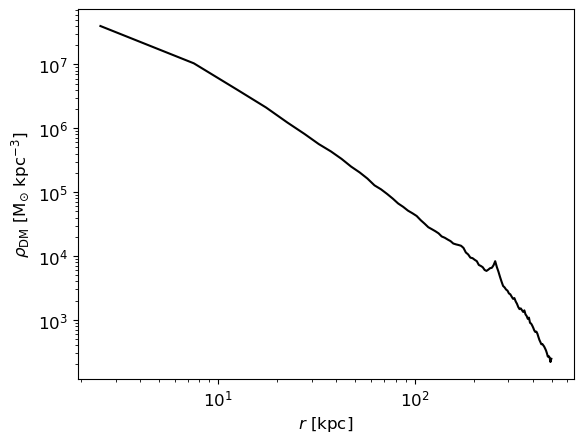

In [102]:
plt.plot(pdm_3d['rbins'].in_units('kpc'),pdm_3d['density'].in_units('Msol kpc^-3'),'k')
plt.xlabel('$r$ [kpc]'); plt.ylabel(r'$\rho_{\rm DM}$ [M$_{\odot}$ kpc$^{-3}$]'); plt.loglog()

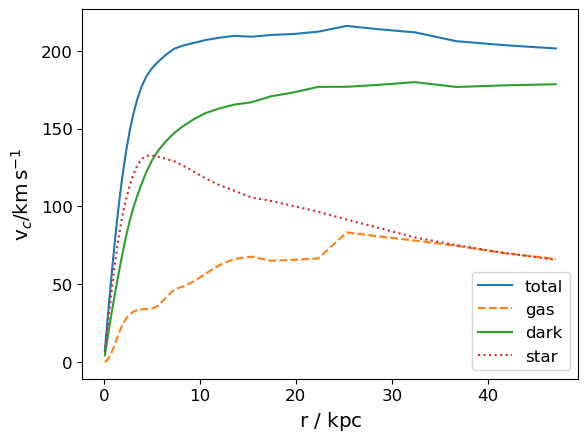

In [114]:
pynbody.plot.profile.rotation_curve(h[0], parts=True, rmin=0.1, rmax=50.0)
plt.legend()

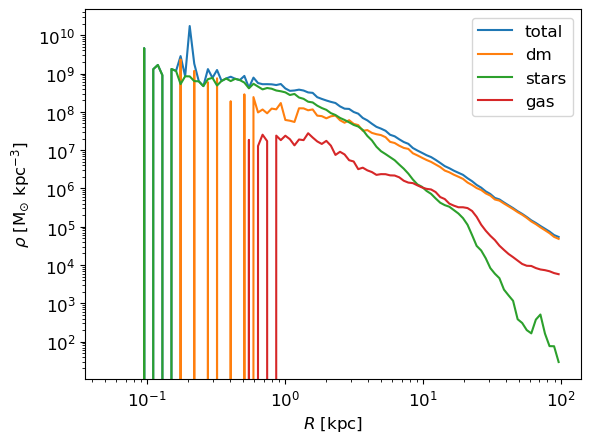

In [116]:
p = profile.Profile( f.star, rmin = '.05 kpc', rmax = '100 kpc', ndim = 3, type='log')
p_dm = profile.Profile(f.dm, rmin = '.05 kpc', rmax = '100 kpc', ndim = 3, type='log')
p_gas = profile.Profile(f.gas, rmin = '.05 kpc', rmax = '100 kpc', ndim = 3, type='log')
p_all = profile.Profile(f, rmin = '.05 kpc', rmax = '100 kpc', ndim = 3, type='log')
for prof, name in zip([p_all, p_dm, p, p_gas],['total', 'dm', 'stars', 'gas']):
    plt.plot(prof['rbins'].in_units('kpc'), prof['density'].in_units('Msol kpc^-3'), label=name)

plt.xlabel('$R$ [kpc]');
plt.ylabel(r'$\rho$ [M$_{\odot}$ kpc$^{-3}$]')
plt.loglog()
plt.legend()

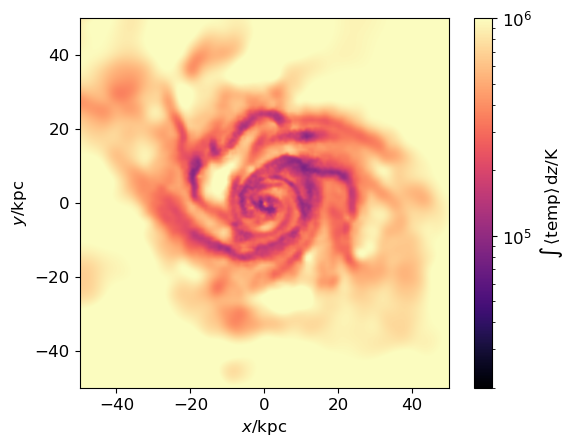

In [106]:
pynbody.plot.image(f.gas, qty='temp', width="100 kpc", cmap="magma", vmin=2e4,vmax=1e6,
                   weight='rho')

In [93]:
snap_path = data_path + '/run_CDM_710_HY/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_HY/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    print([k for k in s['Header'].keys()])

[]


In [ ]:
snap_path = data_path + '/run_CDM_710_HY/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_HY/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    test = s.get('Subhalo')
    print(test)
    print(test['SubhaloMass'])
    print(test['SubhaloVmaxRad'][0])

<HDF5 group "/Subhalo" (50 members)>
<HDF5 dataset "SubhaloMass": shape (174,), type "<f8">
35.8923245454339


In [ ]:
snap_path = data_path + '/run_CDM_710_HY/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_HY/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    print(f['Header'].attrs['NumPart_Total'])
    for n in f['Header'].attrs['NumPart_Total']:
        print(np.cbrt(n))
    print(s['Group/GroupMass'])
    print(s.get('Group'))
    test = s.get('Group')
    print(test['GroupMass'])

[2313708  114400 2190078       0    4734      13]
132.26233412812297
48.54472085833889
129.8633277638242
0.0
16.79098155421193
2.3513346877207577
<HDF5 dataset "GroupMass": shape (431,), type "<f8">
<HDF5 group "/Group" (25 members)>
<HDF5 dataset "GroupMass": shape (431,), type "<f8">


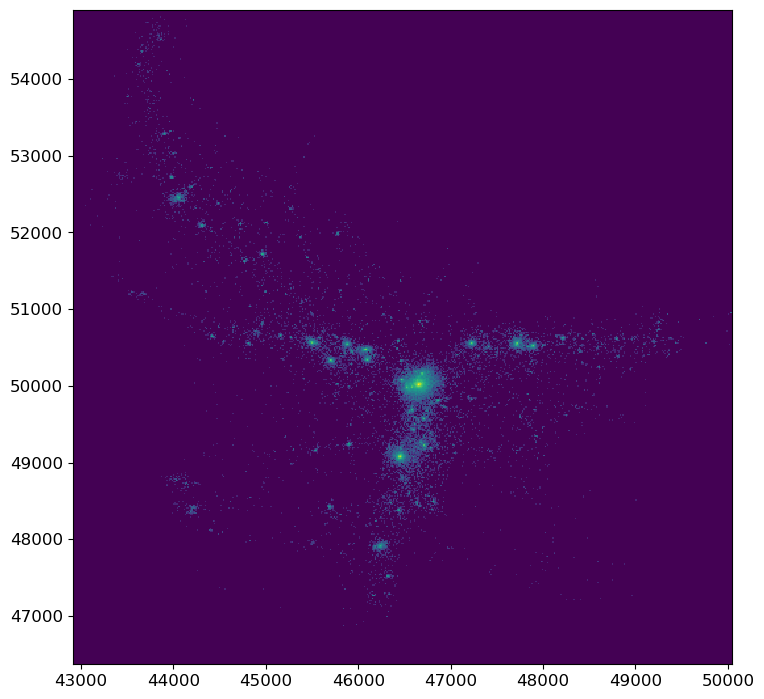

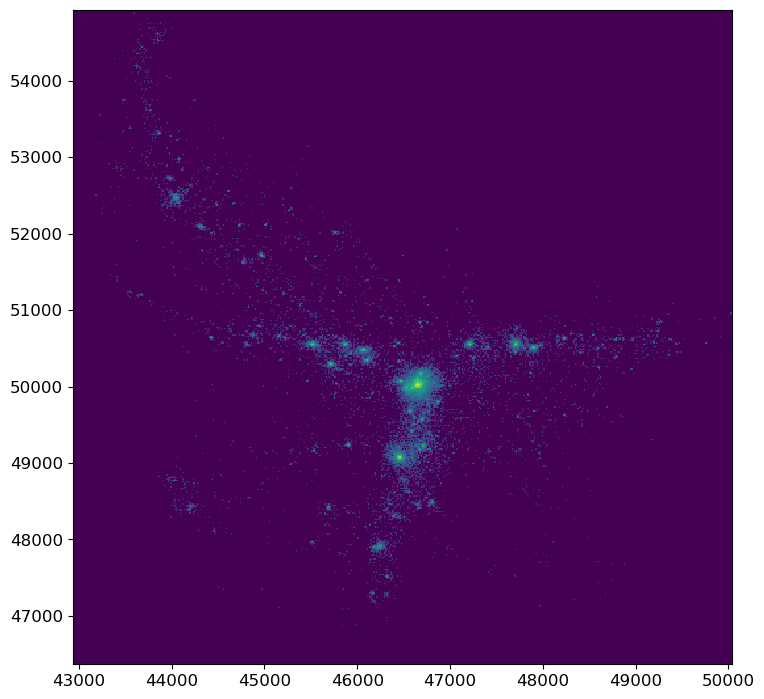

In [ ]:
snap_path = data_path + '/run_CDM_710_HY/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_HY/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    coords = f[f"PartType1/Coordinates"]
    average_z = np.mean(coords[:,2])
    std_z = np.std(coords[:,2])
    #masses = f[f"PartType1/Masses"][()]
    z_slice = (coords[:,2] < (average_z + std_z)) & (coords[:,2] > (average_z - std_z))

    x = coords[:,0][z_slice]
    y = coords[:,1][z_slice]
    #m = masses[z_slice]

#print(np.amax(x) - np.amin(x), np.amax(y) - np.amin(y))
Nbins=500
FIG_HEIGHT = 8.5
FIG_WIDTH = 8.5

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist2d(x, y, norm=LogNorm(clip=True), bins=Nbins)
plt.show()


snap_path = data_path + '/run_2cDM_710_HY_power00_sigma1/snap_127.hdf5'
fof_path = data_path + '/run_2cDM_710_HY_power00_sigma1/fof_subhalo_tab_127.hdf5'

with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    coords = f[f"PartType1/Coordinates"]
    average_z = np.mean(coords[:,2])
    std_z = np.std(coords[:,2])
    #masses = f[f"PartType2/Masses"][()]
    z_slice = (coords[:,2] < (average_z + std_z)) & (coords[:,2] > (average_z - std_z))

    x = coords[:,0][z_slice]
    y = coords[:,1][z_slice]
    #m = masses[z_slice]

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist2d(x, y, norm=LogNorm(clip=True), bins=Nbins)
plt.show()

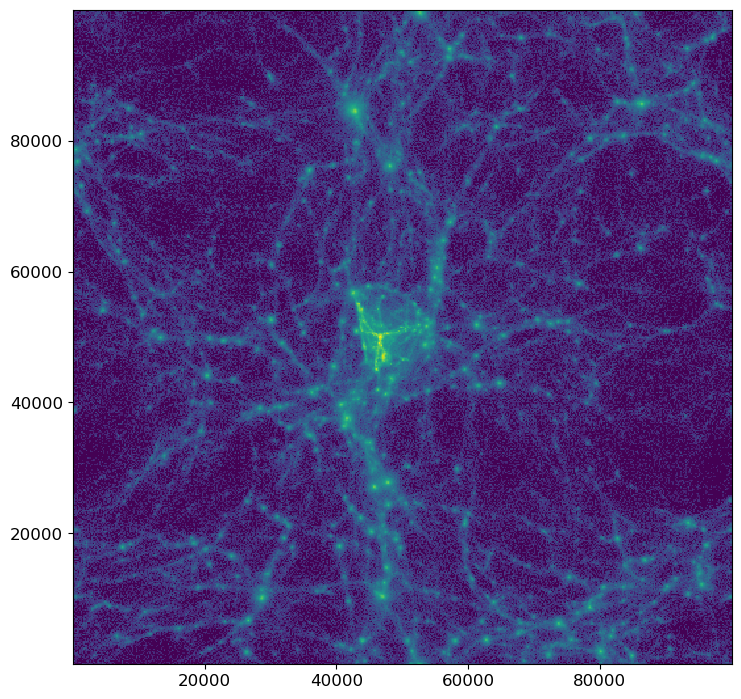

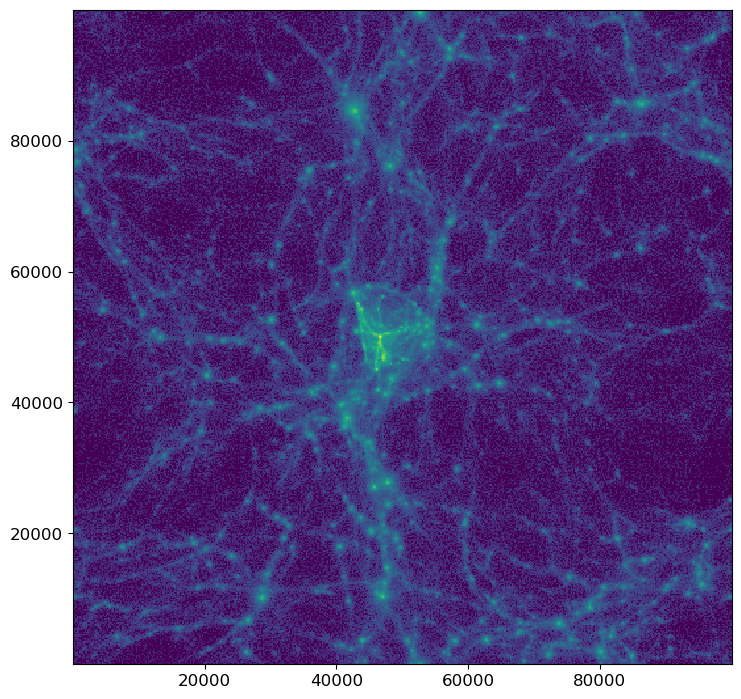

In [ ]:
snap_path = data_path + '/run_CDM_710_HY/snap_127.hdf5'
fof_path = data_path + '/run_CDM_710_HY/fof_subhalo_tab_127.hdf5'
with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    coords = f[f"PartType0/Coordinates"]
    average_z = np.mean(coords[:,2])
    std_z = np.std(coords[:,2])
    #masses = f[f"PartType1/Masses"][()]
    z_slice = (coords[:,2] < (average_z + std_z)) & (coords[:,2] > (average_z - std_z))

    x = coords[:,0][z_slice]
    y = coords[:,1][z_slice]
    #m = masses[z_slice]

#print(np.amax(x) - np.amin(x), np.amax(y) - np.amin(y))
Nbins=500
FIG_HEIGHT = 8.5
FIG_WIDTH = 8.5

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist2d(x, y, norm=LogNorm(clip=True), bins=Nbins)
plt.show()


snap_path = data_path + '/run_2cDM_710_HY_power00_sigma1/snap_127.hdf5'
fof_path = data_path + '/run_2cDM_710_HY_power00_sigma1/fof_subhalo_tab_127.hdf5'

with h5py.File(fof_path, 'r') as s, h5py.File(snap_path, "r") as f:
    coords = f[f"PartType0/Coordinates"]
    average_z = np.mean(coords[:,2])
    std_z = np.std(coords[:,2])
    #masses = f[f"PartType2/Masses"][()]
    z_slice = (coords[:,2] < (average_z + std_z)) & (coords[:,2] > (average_z - std_z))

    x = coords[:,0][z_slice]
    y = coords[:,1][z_slice]
    #m = masses[z_slice]

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.hist2d(x, y, norm=LogNorm(clip=True), bins=Nbins)
plt.show()